In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import os
import math
import sys
from collections import defaultdict

from typing import List, Optional, Union, Dict

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torch
import torch.utils.data
from transformers import AutoTokenizer, BatchEncoding, PreTrainedTokenizerBase

color_pallette = 'muted'
sns.set_theme(style='whitegrid', font_scale=2, palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')
MODELS_FOLDER = os.path.join(PROJECT_FOLDER, 'models')

if PROJECT_FOLDER not in sys.path:
    sys.path.append(PROJECT_FOLDER)
    
data_dir = os.path.join(DATA_FOLDER, 'multiemo2')

SENTIMENT_MAPPING = {
    "text": {
        "meta_plus_m": 'SP',
        "meta_minus_m": 'SN',
        "meta_zero": '0',
        "meta_amb": 'AMB',
    },
    "sentence": {
        "z_plus_m": 'SP',
        "z_minus_m": 'SN',
        "z_zero": '0',
        "z_amb": 'AMB',
    }
}

In [3]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(MODELS_FOLDER, model_name))
print(f"Tokenizer {model_name} loaded.")

Tokenizer bert-base-uncased loaded.


In [4]:
from src.data.data_processing import get_task_processor, get_examples_from_dataset, get_label_id

def get_data(task_name: str, set_name: str, tokenizer: PreTrainedTokenizerBase, raw_data_dir: str):
    processor = get_task_processor(task_name)
    examples = get_examples_from_dataset(processor, raw_data_dir, set_name)

    labels = [example.label for example in examples]
    
    texts_a = []
    texts_b = []
    
    for (ex_index, example) in enumerate(examples):
        texts_a.append(example.text_a)
        if example.text_b is not None:
            texts_b.append(example.text_b)

    if len(texts_a) == len(texts_b):
        text_tokenized = tokenizer(
            texts_a,
            texts_b,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
            truncation=False,
            padding=False,
            return_length=True
        )
    else:
        text_tokenized = tokenizer(
            texts_a,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
            truncation=False,
            padding=False,
            return_length=True
        )
    
    text_tokens = text_tokenized['input_ids']
    lengths = text_tokenized['length']
    return texts_a, text_tokens, labels, lengths

In [5]:
def get_split_data(split_name: str, level: str, raw_data_dir: str):
    texts = []
    labels = []
    domains = []
    for domain in ['hotels', 'medicine', 'products', 'reviews']:
        task_name = f'multiemo_en_{domain}_{level}'
        processor = get_task_processor(task_name)
        examples = get_examples_from_dataset(processor, raw_data_dir, split_name)
        
        for (ex_index, example) in enumerate(examples):
            texts.append(example.text_a)
            labels.append(example.label)
            
            domain_val = domain
            if domain_val == 'reviews':
                domain_val = 'school'
            domains.append(domain_val)

    df = pd.DataFrame({'text': texts, 'label': labels, 'domain': domains})
    df['label'].replace(SENTIMENT_MAPPING[level], inplace=True)     
    return df

In [6]:
def analyse(task_name, set_name, tokenizer, data_dir):
    texts, text_tokens, labels, lengths = get_data(task_name, set_name=set_name, tokenizer=tokenizer, raw_data_dir=data_dir)

    task_name_display = task_name.replace('_', ' ').upper()
    set_name_diaplay = set_name.upper()
    
    df = pd.DataFrame({'text': texts, 'label': labels, 'length': lengths})
    labels_unique = np.sort(df.label.unique())
    
    # Labels count
    fig = plt.figure(figsize=(16, 6.5))
    gs = fig.add_gridspec(1, 3)
    
    ax1 = fig.add_subplot(gs[0])
    sns.countplot(x='label', data=df, order=labels_unique, ax=ax1)
    ax1.set_title(f'Labels count')
    fig.tight_layout()

    # Seuqence length histogram
    ax2 = fig.add_subplot(gs[1:])
    sns.histplot(x='length', data=df, ax=ax2)
    max_val = max([p.get_height() for p in ax2.patches])
    for q, ls in zip([0.75, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)),  (0, (5, 2))]):
        qv = int(df['length'].quantile(q))
        ax2.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
        ax2.annotate(qv, xy=(qv, max_val * 0.8), xytext = (qv + 9, max_val * 0.85),
                     arrowprops=dict(arrowstyle = "->", color='black'))

    ax2.legend(title='Quantile')
    ax2.set_title(f'Sequence length histogram')
    
    fig.suptitle(f'{task_name_display} -- {set_name_diaplay} set')
    fig.tight_layout()
#     fig.savefig(f'{task_name}_{set_name}_analysis.png', dpi=300)

In [7]:
pal = sns.color_palette('tab10')
pal.as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [8]:
print(pal.as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [10]:
def plot_label_counts(df_plot, order, ax, title=''):
    sns.countplot(data=df_plot, x='label', order=order, ax=ax, edgecolor="0",
                  palette=['#2ca02c', '#d62728', '#7f7f7f', '#ec7241'])
    ax.set_title(title)

    heights = []

    x_offset = 0
    y_offset = 0.02 * max([p.get_height() for p in ax.patches])

    for p in ax.patches:
        _x = p.get_x() + p.get_width()/2 + x_offset
        _y = p.get_y() + p.get_height()
        value = p.get_height()
        if np.isnan(value):
            _y = 0
            value = 0
        else:
            value = int(value)
        _y += y_offset
        ax.text(_x, _y, value, ha="center", fontsize=18)

        heights.append(value)

    ax.set_ylim(top=1.1 * max(heights))

def plot_domain_labels(df, level, set_name):
    domains = df.domain.unique()
    order = list(SENTIMENT_MAPPING[level].values())
    fig, axis = plt.subplots(1, 1+len(domains), figsize=(3.5*(1+len(domains)), 4), constrained_layout=True)
            
    plot_label_counts(df, order, title='All', ax=axis[0])
    
    for d, ax in zip(domains, axis[1:]):
        df_plot = df[df.domain == d]
        plot_label_counts(df_plot, order, f'{d.title()}', ax=ax)


    fig.savefig(f'{level}_{set_name}_labels.eps', bbox_inches='tight')
    
    
def plot_all_split_domain_labels(level):
    df_list = []
    split_names = ['train', 'dev', 'test'] 
    
    for split_name in split_names:
        df = get_split_data(split_name, level=level, raw_data_dir=data_dir)
        df['split'] = split_name
        df_list.append(df)

    df = pd.concat(df_list, ignore_index=True)
     
    domains = df.domain.unique()
    order = list(SENTIMENT_MAPPING[level].values())
    
    rows = len(split_names)
    cols = 1 + len(domains)
#     fig, axis = plt.subplots(rows, cols, figsize=(3.5*cols, 4.2*rows), constrained_layout=True)
    fig, axis = plt.subplots(rows, cols, figsize=(3.5*cols, 3.5*rows), constrained_layout=True)
    
    for split_name, row_axis in zip(split_names, axis):
        split_df = df[df['split'] == split_name]
        plot_label_counts(split_df, order, title='All', ax=row_axis[0])
        row_axis[0].set_ylabel(f'{split_name.upper()}\ncount')
        
        for d, ax in zip(domains, row_axis[1:]):
            df_plot = split_df[split_df.domain == d]
            plot_label_counts(df_plot, order, title=f'{d.title()}', ax=ax)
            ax.set_title(f'{d.title()}', fontsize=26)

    sns.despine(fig)
    fig.savefig(f'{level}_labels.eps', bbox_inches='tight')
    
    
def analyze_text_length(texts, text_tokens, labels, lengths, task_name, set_name, right_xlim=None, **kwargs):
    task_name_display = task_name.replace('_', ' ').upper()
    set_name_diaplay = set_name.upper()
    
    df = pd.DataFrame({'text': texts, 'label': labels, 'length': lengths})
    labels_unique = np.sort(df.label.unique())
    
    # Labels count
    fig, ax2 = plt.subplots(figsize=(12, 5.5), constrained_layout=True)

    # Seuqence length histogram
    sns.histplot(x='length', data=df, ax=ax2, alpha=1.0, **kwargs)
    
    
    if right_xlim is not None:
        ax2.set_xlim(left=0, right=right_xlim)
        
    _, right_lim = ax2.get_xlim()
    text_offset = 0.05 * right_lim
    
    
    max_val = max([p.get_height() for p in ax2.patches])
    for q, ls in zip([0.75, 0.95, 0.99], [(0, (5, 3)), (0, (5, 6)),  (0, (5, 9))]):
        qv = int(df['length'].quantile(q))
        ax2.axvline(qv, ls=(0, (6, 4)), lw=2.2, color='red', zorder=3)
        ax2.annotate(r'$q_{{{}}}={}$'.format(str(round(q,2)), qv), xy=(qv, max_val * 0.7), 
                     xytext = (qv + text_offset, max_val * 0.725),
                     arrowprops=dict(arrowstyle = "->", color='black'), fontsize=22)


#     ax2.legend(title='Quantile')
    ax2.set_xlabel(f'Sequence length')
#     fig.tight_layout()
    sns.despine(fig)
    fig.savefig(f'{task_name}_{set_name}_text_length_analysis.eps', bbox_inches='tight')

In [19]:
# for level in ['sentence', 'text']:
#     df_list = []
#     split_names = ['train', 'dev', 'test'] 

#     for split_name in split_names:
#         df = get_split_data(split_name, level=level, raw_data_dir=data_dir)
#         df['split'] = split_name
#         df_list.append(df)

#     df = pd.concat(df_list, ignore_index=True)

#     domains = df.domain.unique()
#     order = list(SENTIMENT_MAPPING[level].values())

#     rows = len(split_names)
#     cols = 1+len(domains)
#     fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

#     title = 'Poziom zdań' if level == 'sentence' else 'Poziom tekstów'

#     plot_label_counts(df, order, title=title, ax=ax)
#     ax.set_ylabel(f'liczba')
#     ax.set_xlabel(f'klasa')
#     fig.savefig(f'{level}_labels_all.svg', bbox_inches='tight')

## Poziom zdaniowy

In [11]:
task_name = 'multiemo_en_all_sentence'
set_name = 'train'
texts, text_tokens, labels, lengths = get_data(task_name, set_name=set_name, tokenizer=tokenizer, raw_data_dir=data_dir)

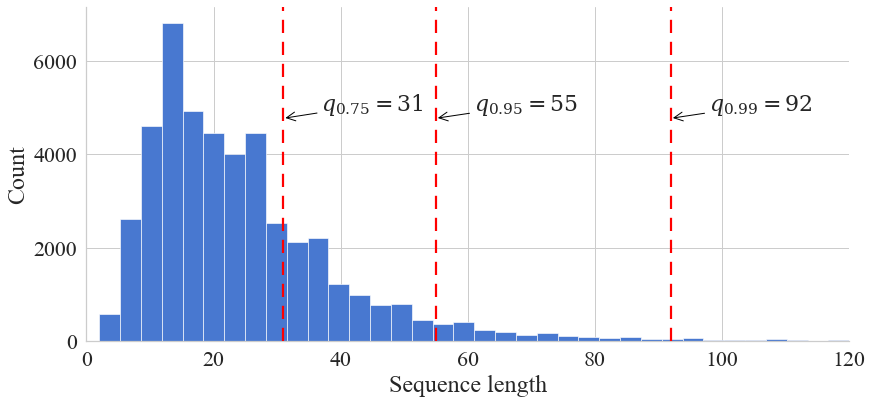

In [12]:
analyze_text_length(texts, text_tokens, labels, lengths, task_name=task_name, set_name=set_name, right_xlim=120, bins=100)

In [145]:
# task_name = 'multiemo_en_all_sentence'
# set_name = 'train'
# texts, text_tokens, labels, lengths = get_data(task_name, set_name=set_name, tokenizer=tokenizer, raw_data_dir=data_dir)

# task_name_display = task_name.replace('_', ' ').upper()
# set_name_diaplay = set_name.upper()

# df = pd.DataFrame({'text': texts, 'label': labels, 'length': lengths})
# labels_unique = np.sort(df.label.unique())

# # Labels count
# fig, ax1 = plt.subplots(figsize=(16, 6))

# # Seuqence length histogram
# # sns.histplot(x='length', data=df, ax=ax2, **kwargs)
# sns.violinplot(x='length', data=df, ax=ax1)
# # max_val = max([p.get_height() for p in ax1.patches])

# # max_val = 100

# # for q, ls in zip([0.75, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)),  (0, (5, 2))]):
# #     qv = int(df['length'].quantile(q))
# #     ax1.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
# #     ax1.annotate(qv, xy=(qv, max_val * 0.8), xytext = (qv + 9, max_val * 0.85),
# #                  arrowprops=dict(arrowstyle = "->", color='black'))

# # ax1.legend(title='Quantile')
# ax1.set_xlabel(f'Sequence length')
# fig.tight_layout()

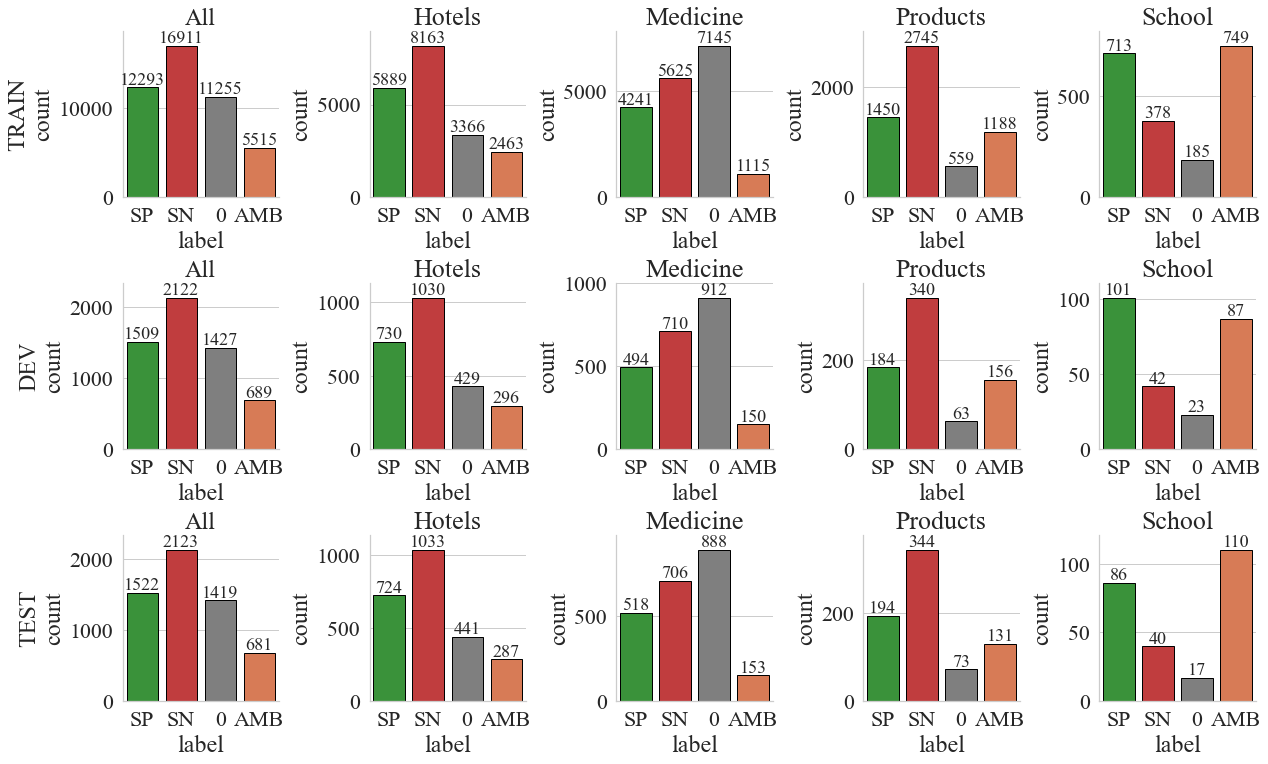

In [28]:
level = 'sentence'
plot_all_split_domain_labels(level=level)

In [8]:
# level = 'sentence'   
# for set_name in ['train', 'dev', 'test']:
#     df = get_split_data(set_name, level=level, raw_data_dir=data_dir)
#     plot_domain_labels(df, level=level, set_name=set_name)

In [10]:
# task_name = 'multiemo_en_all_sentence'
# data_dir = os.path.join(DATA_FOLDER, 'multiemo2')

# for set_name in ['train', 'dev', 'test']:
#     analyse(task_name, set_name, tokenizer, data_dir)

## Poziom tekstowy

In [13]:
task_name = 'multiemo_en_all_text'
data_dir = os.path.join(DATA_FOLDER, 'multiemo2')
set_name = 'train'
texts, text_tokens, labels, lengths = get_data(task_name, set_name=set_name, tokenizer=tokenizer, raw_data_dir=data_dir)

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


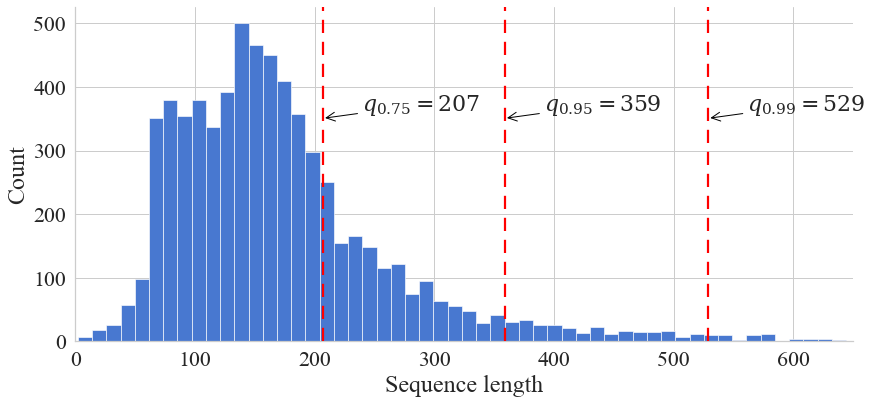

In [14]:
analyze_text_length(texts, text_tokens, labels, lengths, task_name=task_name, set_name=set_name, right_xlim=650, bins=100)

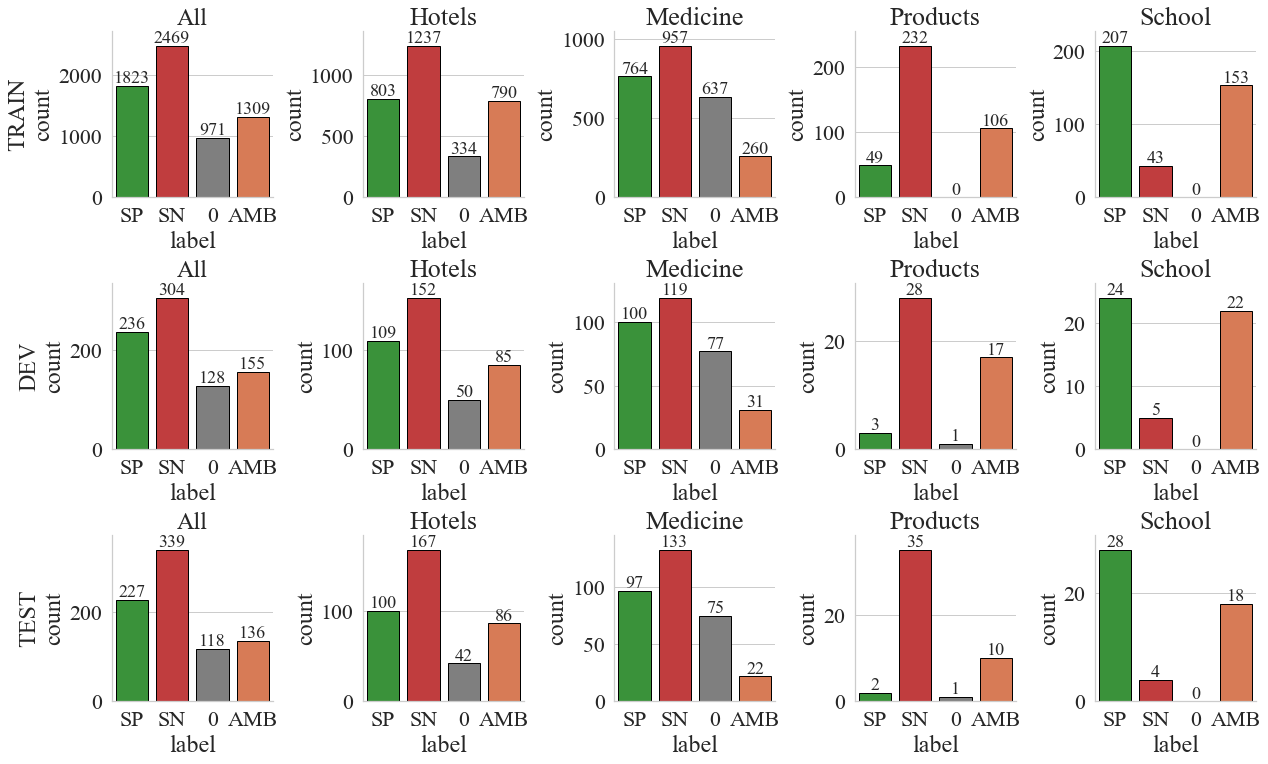

In [29]:
level = 'text'   
plot_all_split_domain_labels(level=level)

In [43]:
# level = 'text'   
# for set_name in ['train', 'dev', 'test']:
#     df = get_split_data(set_name, level=level, raw_data_dir=data_dir)
#     plot_domain_labels(df, level=level, set_name=set_name)

In [36]:
# task_name = 'multiemo_en_all_text'
# data_dir = os.path.join(DATA_FOLDER, 'multiemo2')

# for set_name in ['train', 'dev', 'test']:
#     analyse(task_name, set_name, tokenizer, data_dir)